# **Automated Valuation Models**

### **Reserach Question :** How does machine learning regression models performance compare to classical linear and parametric regression models such as Ordinary Least Squares?

### **Topic :**  Does estimation window size affects accuracy (rolling window)? 

### To test whether or not estimation window size affects accuracy, Sliding method and Expanding method will be used.

## **Data**
Data : Melbourne housing clearance data from Jan 2016 to 2018

Link : https://www.kaggle.com/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv

Type : Regression

## **Target, Evaluation index**

Target: Price

Evaluation criteria: Root Mean Square Error (RMSE)


###**Short explaination of some features**

Price: Price in dollars

Rooms: Number of rooms

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD

Regionname: General Region (West, North West, North, North east …etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size

BuildingArea: Building Size

CouncilArea: Governing council for the area


In [134]:
#!pip install pandas-profiling==2.*

In [135]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

.











#**1. A first look to the dataset**



In [136]:
# Data upload
#from google.colab import files
#myfile = files.upload()

In [137]:
df= pd.read_csv("Melbourne_housing_FULL.csv")

In [138]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [139]:
df.shape

(34857, 21)

In [140]:
# Profiling

#from pandas_profiling import ProfileReport
#ProfileReport(df)

In [141]:
# Converting Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Rooms and Bedroom2 have high correlation.So Bedroom2 must be dropped
df=df.drop(axis=1,columns='Bedroom2')

# Postcode is categorial, shoule be object

# Bathroom ,Car, Yearbuilt should be integer

In [142]:
df.describe()

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


In [143]:
# When BuildingArea is 0 or Landsize is 0

display(len(df[(df['BuildingArea'] == 0)]),len(df[(df['Landsize'] == 0)]))

76

2437

In [144]:
# BuildingArea and Landsize cannot be 0, so drop

df=df[~(df['BuildingArea'] == 0)]
df=df[~(df['Landsize'] == 0)]
display(len(df[(df['BuildingArea'] == 0)]),len(df[(df['Landsize'] == 0)]))

0

0

In [145]:
# when YearBuilt is after 2019

len(df[(df['YearBuilt'] >= 2019)])

2

In [146]:
# Data is form 2016 to 2018 so 2019 data could not exist. Drop.

df=df[~(df['YearBuilt'] >= 2019)]
len(df[(df['YearBuilt'] >= 2019)])

0

In [147]:
# reset index
df = df.reset_index()

In [148]:
df=df.drop(axis=1,columns='index')

#**2. Data cleaning**

##**2.1. Duplitcate values**

In [149]:
# Check Duplitcate values

len(df[df.duplicated()==True]) 

1

In [150]:
# Remove duplicate values

df=df.drop_duplicates()
len(df[df.duplicated()==True]) 

0

##**2.2. Missing values**

In [151]:
# Check Missing values

df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7098
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bathroom          8226
Car               8726
Landsize         11790
BuildingArea     20005
YearBuilt        18472
CouncilArea          3
Lattitude         7971
Longtitude        7971
Regionname           3
Propertycount        3
dtype: int64

In [152]:
# Inserting the median on the missing values of numeric data

df['Price']= df['Price'].fillna(df['Price'].median())
df['Distance']= df['Distance'].fillna(df['Distance'].median())
df['Landsize']= df['Landsize'].fillna(df['Landsize'].median())
df['BuildingArea']= df['BuildingArea'].fillna(df['BuildingArea'].median())
df['YearBuilt']= df['YearBuilt'].fillna(df['YearBuilt'].median())
df['Lattitude']= df['Lattitude'].fillna(df['Lattitude'].median())
df['Longtitude']= df['Longtitude'].fillna(df['Longtitude'].median())

In [153]:
# Putting Modes on Missing values in Categorical Data

df['Car']= df['Car'].fillna(df['Car'].mode()[0])
df['Bathroom']= df['Bathroom'].fillna(df['Bathroom'].mode()[0])
df['Postcode']= df['Postcode'].fillna(df['Postcode'].mode()[0])
df['CouncilArea']= df['CouncilArea'].fillna(df['CouncilArea'].mode()[0])
df['Regionname']= df['Regionname'].fillna(df['Regionname'].mode()[0])
df['Propertycount']= df['Propertycount'].fillna(df['Propertycount'].mode()[0])

In [154]:
# after processing missing values
df.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [155]:
# change Bathroom, car and YearBuilt to integer

df['Bathroom']=df['Bathroom'].astype('int64')
df['Car']=df['Car'].astype('int64')
df['YearBuilt']=df['YearBuilt'].astype('int64')

# Change Postcode to object

df['Postcode']= df['Postcode'].astype('object')

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32341
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         32341 non-null  object        
 1   Address        32341 non-null  object        
 2   Rooms          32341 non-null  int64         
 3   Type           32341 non-null  object        
 4   Price          32341 non-null  float64       
 5   Method         32341 non-null  object        
 6   SellerG        32341 non-null  object        
 7   Date           32341 non-null  datetime64[ns]
 8   Distance       32341 non-null  float64       
 9   Postcode       32341 non-null  object        
 10  Bathroom       32341 non-null  int64         
 11  Car            32341 non-null  int64         
 12  Landsize       32341 non-null  float64       
 13  BuildingArea   32341 non-null  float64       
 14  YearBuilt      32341 non-null  int64         
 15  CouncilArea    3234

##**2.3. Feature engineering**

In [157]:
# Create Year and doy(day of year)

df['Year'] = df['Date'].dt.year

df['doy'] = df['Date'].dt.dayofyear

In [158]:
#Create a feature called season using the doy feature

spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
#winter = else

v=[]
for i in df['doy']:

  if i in spring:
    season='spring'
  elif i in summer:
    season = 'summer'
  elif i in fall:
    season = 'fall'
  else:
    season = 'winter'
  v.append(season)  

df['season']= pd.Series(v)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32341
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         32341 non-null  object        
 1   Address        32341 non-null  object        
 2   Rooms          32341 non-null  int64         
 3   Type           32341 non-null  object        
 4   Price          32341 non-null  float64       
 5   Method         32341 non-null  object        
 6   SellerG        32341 non-null  object        
 7   Date           32341 non-null  datetime64[ns]
 8   Distance       32341 non-null  float64       
 9   Postcode       32341 non-null  object        
 10  Bathroom       32341 non-null  int64         
 11  Car            32341 non-null  int64         
 12  Landsize       32341 non-null  float64       
 13  BuildingArea   32341 non-null  float64       
 14  YearBuilt      32341 non-null  int64         
 15  CouncilArea    3234

#**3. Machine Learning**

##**3.1 Split Data**


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32341
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         32341 non-null  object        
 1   Address        32341 non-null  object        
 2   Rooms          32341 non-null  int64         
 3   Type           32341 non-null  object        
 4   Price          32341 non-null  float64       
 5   Method         32341 non-null  object        
 6   SellerG        32341 non-null  object        
 7   Date           32341 non-null  datetime64[ns]
 8   Distance       32341 non-null  float64       
 9   Postcode       32341 non-null  object        
 10  Bathroom       32341 non-null  int64         
 11  Car            32341 non-null  int64         
 12  Landsize       32341 non-null  float64       
 13  BuildingArea   32341 non-null  float64       
 14  YearBuilt      32341 non-null  int64         
 15  CouncilArea    3234

In [161]:
#Drop features that no effect on price

df= df.drop(['Suburb', 'Address', 'Method', 'SellerG', 'Postcode', 'CouncilArea', 'doy'], axis=1)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32341
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Rooms          32341 non-null  int64         
 1   Type           32341 non-null  object        
 2   Price          32341 non-null  float64       
 3   Date           32341 non-null  datetime64[ns]
 4   Distance       32341 non-null  float64       
 5   Bathroom       32341 non-null  int64         
 6   Car            32341 non-null  int64         
 7   Landsize       32341 non-null  float64       
 8   BuildingArea   32341 non-null  float64       
 9   YearBuilt      32341 non-null  int64         
 10  Lattitude      32341 non-null  float64       
 11  Longtitude     32341 non-null  float64       
 12  Regionname     32341 non-null  object        
 13  Propertycount  32341 non-null  float64       
 14  Year           32341 non-null  int64         
 15  season         3234

In [163]:
# Onehot encoding

hD= pd.get_dummies(df, columns= ['Type', 'Regionname', 'season'])
hD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32341
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Rooms                                  32341 non-null  int64         
 1   Price                                  32341 non-null  float64       
 2   Date                                   32341 non-null  datetime64[ns]
 3   Distance                               32341 non-null  float64       
 4   Bathroom                               32341 non-null  int64         
 5   Car                                    32341 non-null  int64         
 6   Landsize                               32341 non-null  float64       
 7   BuildingArea                           32341 non-null  float64       
 8   YearBuilt                              32341 non-null  int64         
 9   Lattitude                              32341 non-null  float6

In [164]:
hD['Date'].value_counts

<bound method IndexOpsMixin.value_counts of 0       2016-03-09
1       2016-03-12
2       2016-04-02
3       2017-04-03
4       2017-04-03
           ...    
32337   2018-02-24
32338   2018-02-24
32339   2018-02-24
32340   2018-02-24
32341   2018-02-24
Name: Date, Length: 32341, dtype: datetime64[ns]>

###**Whole period is 24 months with 2016.03 ~ 2018.02**
###**Test data will be 2 months start with 2017.03 ~ 2017.04 to 2018.01~2018.02 for all mothod and period**
###**Train data for Expanding method start with 2016.03 ~ 2017.02 to 2016.03 ~ 2017.12**
###**Sliding method will have 6 models. Each model has train data for 2~7 months respectively**  

In [165]:
# Split Data for Expanding Method

# Train data for 2016.03 ~ 2017.02
train_ex_1 = hD[hD['Date']<='2017.02.28']

# Train data for 2016.03 ~ 2017.03
train_ex_2 =  hD[hD['Date']<='2017.03.31']

# Train data for 2016.03 ~ 2017.4
train_ex_3 =  hD[hD['Date']<='2017.04.30']

# Train data for 2016.03 ~ 2017.05
train_ex_4 = hD[hD['Date']<='2017.05.31']

# Train data for 2016.03 ~ 2017.06
train_ex_5 = hD[hD['Date']<='2017.06.30']

# Train data for 2016.03 ~ 2017.07
train_ex_6 = hD[hD['Date']<='2017.07.31']

# Train data for 2016.03 ~ 2017.08
train_ex_7 = hD[hD['Date']<='2017.08.31']

# Train data for 2016.03 ~ 2017.09
train_ex_8 = hD[hD['Date']<='2017.09.30']

# Train data for 2016.03 ~ 2017.10
train_ex_9 = hD[hD['Date']<='2017.10.31']

# Train data for 2016.03 ~ 2017.11
train_ex_10 = hD[hD['Date']<='2017.11.30']

# Train data for 2016.03 ~ 2017.12
train_ex_11 = hD[hD['Date']<='2017.12.31']

In [166]:
# Split Data for sliding Method-1 (2 months for each train data set)

# Train data for 2017.01 ~ 2017.02
train_sl1_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.03
train_sl1_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.04
train_sl1_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.05
train_sl1_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.06
train_sl1_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.07
train_sl1_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.06.01')]

# Train data for 2017.07 ~ 2017.08
train_sl1_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.07.01')]

# Train data for 2017.08 ~ 2017.09
train_sl1_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.08.01')]

# Train data for 2017.09 ~ 2017.10
train_sl1_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.09.01')]

# Train data for 2017.10 ~ 2017.11
train_sl1_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.10.01')]

# Train data for 2017.11 ~ 2017.12
train_sl1_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.11.01')]

In [167]:
# Split Data for sliding Method-2 (3 months for each train data set)

# Train data for 2016.12 ~ 2017.02
train_sl2_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2016.12.01')]

# Train data for 2017.01 ~ 2017.03
train_sl2_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.04
train_sl2_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.05
train_sl2_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.06
train_sl2_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.07
train_sl2_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.08
train_sl2_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.06.01')]

# Train data for 2017.07 ~ 2017.09
train_sl2_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.07.01')]

# Train data for 2017.08 ~ 2017.10
train_sl2_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.08.01')]

# Train data for 2017.09 ~ 2017.11
train_sl2_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.09.01')]

# Train data for 2017.10 ~ 2017.12
train_sl2_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.10.01')]

In [168]:
# Split Data for sliding Method-3 (4 months for each train data set)

# Train data for 2016.11 ~ 2017.02
train_sl3_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2016.11.01')]

# Train data for 2016.12 ~ 2017.03
train_sl3_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2016.12.01')]

# Train data for 2017.01 ~ 2017.04
train_sl3_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.05
train_sl3_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.06
train_sl3_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.07
train_sl3_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.08
train_sl3_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.09
train_sl3_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.06.01')]

# Train data for 2017.07 ~ 2017.10
train_sl3_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.07.01')]

# Train data for 2017.08 ~ 2017.11
train_sl3_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.08.01')]

# Train data for 2017.09 ~ 2017.12
train_sl3_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.09.01')]

In [169]:
# Split Data for sliding Method-4 (5 months for each train data set)

# Train data for 2016.10 ~ 2017.02
train_sl4_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2016.10.01')]

# Train data for 2016.11 ~ 2017.03
train_sl4_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2016.11.01')]

# Train data for 2016.12 ~ 2017.04
train_sl4_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2016.12.01')]

# Train data for 2017.01 ~ 2017.05
train_sl4_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.06
train_sl4_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.07
train_sl4_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.08
train_sl4_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.09
train_sl4_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.10
train_sl4_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.06.01')]

# Train data for 2017.07 ~ 2017.11
train_sl4_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.07.01')]

# Train data for 2017.08 ~ 2017.12
train_sl4_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.08.01')]

In [170]:
# Split Data for sliding Method-5 (6 months for each train data set)

# Train data for 2016.09 ~ 2017.02
train_sl5_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2016.09.01')]

# Train data for 2016.10 ~ 2017.03
train_sl5_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2016.10.01')]

# Train data for 2016.11 ~ 2017.04
train_sl5_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2016.11.01')]

# Train data for 2016.12 ~ 2017.05
train_sl5_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2016.12.01')]

# Train data for 2017.01 ~ 2017.06
train_sl5_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.07
train_sl5_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.08
train_sl5_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.09
train_sl5_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.10
train_sl5_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.11
train_sl5_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.06.01')]

# Train data for 2017.07 ~ 2017.12
train_sl5_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.07.01')]

In [171]:
# Split Data for sliding Method-6 (7 months for each train data set)

# Train data for 2016.08 ~ 2017.02
train_sl6_1 = hD[(hD['Date']<='2017.02.28')& (hD['Date']>='2016.08.01')]

# Train data for 2016.09 ~ 2017.03
train_sl6_2 = hD[(hD['Date']<='2017.03.31')& (hD['Date']>='2016.09.01')]

# Train data for 2016.10 ~ 2017.04
train_sl6_3 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2016.10.01')]

# Train data for 2016.11 ~ 2017.05
train_sl6_4 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2016.11.01')]

# Train 6ata for 2016.12 ~ 2017.06
train_sl6_5 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2016.12.01')]

# Train data for 2017.01 ~ 2017.07
train_sl6_6 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.01.01')]

# Train data for 2017.02 ~ 2017.08
train_sl6_7 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.02.01')]

# Train data for 2017.03 ~ 2017.09
train_sl6_8 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.03.01')]

# Train data for 2017.04 ~ 2017.10
train_sl6_9 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.04.01')]

# Train data for 2017.05 ~ 2017.11
train_sl6_10 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.05.01')]

# Train data for 2017.06 ~ 2017.12
train_sl6_11 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.06.01')]

In [172]:
# Test Data ( used in all methods.)

# Test data for 2017.03 ~ 2017.04
test_1 = hD[(hD['Date']<='2017.04.30')& (hD['Date']>='2017.03.01')]

# Test data for 2017.04 ~ 2017.05
test_2 = hD[(hD['Date']<='2017.05.31')& (hD['Date']>='2017.04.01')]

# Test data for 2017.05 ~ 2017.06
test_3 = hD[(hD['Date']<='2017.06.30')& (hD['Date']>='2017.05.01')]

# Test data for 2017.06 ~ 2017.07
test_4 = hD[(hD['Date']<='2017.07.31')& (hD['Date']>='2017.06.01')]

# Test data for 2017.07 ~ 2017.08
test_5 = hD[(hD['Date']<='2017.08.31')& (hD['Date']>='2017.07.01')]

# Test data for 2017.08 ~ 2017.09
test_6 = hD[(hD['Date']<='2017.09.30')& (hD['Date']>='2017.08.01')]

# Test data for 2017.09 ~ 2017.10
test_7 = hD[(hD['Date']<='2017.10.31')& (hD['Date']>='2017.09.01')]

# Test data for 2017.10 ~ 2017.11
test_8 = hD[(hD['Date']<='2017.11.30')& (hD['Date']>='2017.10.01')]

# Test data for 2017.11 ~ 2017.12
test_9 = hD[(hD['Date']<='2017.12.31')& (hD['Date']>='2017.11.01')]

# Test data for 2017.12 ~ 2018.01
test_10 = hD[(hD['Date']<='2018.01.31')& (hD['Date']>='2017.12.01')]

# Test data for 2018.01 ~ 2018.02
test_11 = hD[(hD['Date']<='2018.02.28')& (hD['Date']>='2018.01.01')]

In [173]:
# drop Date column to do regression

train_ex_1 = train_ex_1.drop(axis=1,columns='Date')
train_ex_2 = train_ex_2.drop(axis=1,columns='Date')
train_ex_3 = train_ex_3.drop(axis=1,columns='Date')
train_ex_4 = train_ex_4.drop(axis=1,columns='Date')
train_ex_5 = train_ex_5.drop(axis=1,columns='Date')
train_ex_6 = train_ex_6.drop(axis=1,columns='Date')
train_ex_7 = train_ex_7.drop(axis=1,columns='Date')
train_ex_8 = train_ex_8.drop(axis=1,columns='Date')
train_ex_9 = train_ex_9.drop(axis=1,columns='Date')
train_ex_10 = train_ex_10.drop(axis=1,columns='Date')
train_ex_11 = train_ex_11.drop(axis=1,columns='Date')

train_sl1_1 = train_sl1_1.drop(axis=1,columns='Date')
train_sl1_2 = train_sl1_2.drop(axis=1,columns='Date')
train_sl1_3 = train_sl1_3.drop(axis=1,columns='Date')
train_sl1_4 = train_sl1_4.drop(axis=1,columns='Date')
train_sl1_5 = train_sl1_5.drop(axis=1,columns='Date')
train_sl1_6 = train_sl1_6.drop(axis=1,columns='Date')
train_sl1_7 = train_sl1_7.drop(axis=1,columns='Date')
train_sl1_8 = train_sl1_8.drop(axis=1,columns='Date')
train_sl1_9 = train_sl1_9.drop(axis=1,columns='Date')
train_sl1_10 = train_sl1_10.drop(axis=1,columns='Date')
train_sl1_11 = train_sl1_11.drop(axis=1,columns='Date')

train_sl2_1 = train_sl2_1.drop(axis=1,columns='Date')
train_sl2_2 = train_sl2_2.drop(axis=1,columns='Date')
train_sl2_3 = train_sl2_3.drop(axis=1,columns='Date')
train_sl2_4 = train_sl2_4.drop(axis=1,columns='Date')
train_sl2_5 = train_sl2_5.drop(axis=1,columns='Date')
train_sl2_6 = train_sl2_6.drop(axis=1,columns='Date')
train_sl2_7 = train_sl2_7.drop(axis=1,columns='Date')
train_sl2_8 = train_sl2_8.drop(axis=1,columns='Date')
train_sl2_9 = train_sl2_9.drop(axis=1,columns='Date')
train_sl2_10 = train_sl2_10.drop(axis=1,columns='Date')
train_sl2_11 = train_sl2_11.drop(axis=1,columns='Date')

train_sl3_1 = train_sl3_1.drop(axis=1,columns='Date')
train_sl3_2 = train_sl3_2.drop(axis=1,columns='Date')
train_sl3_3 = train_sl3_3.drop(axis=1,columns='Date')
train_sl3_4 = train_sl3_4.drop(axis=1,columns='Date')
train_sl3_5 = train_sl3_5.drop(axis=1,columns='Date')
train_sl3_6 = train_sl3_6.drop(axis=1,columns='Date')
train_sl3_7 = train_sl3_7.drop(axis=1,columns='Date')
train_sl3_8 = train_sl3_8.drop(axis=1,columns='Date')
train_sl3_9 = train_sl3_9.drop(axis=1,columns='Date')
train_sl3_10 = train_sl3_10.drop(axis=1,columns='Date')
train_sl3_11 = train_sl3_11.drop(axis=1,columns='Date')

train_sl4_1 = train_sl4_1.drop(axis=1,columns='Date')
train_sl4_2 = train_sl4_2.drop(axis=1,columns='Date')
train_sl4_3 = train_sl4_3.drop(axis=1,columns='Date')
train_sl4_4 = train_sl4_4.drop(axis=1,columns='Date')
train_sl4_5 = train_sl4_5.drop(axis=1,columns='Date')
train_sl4_6 = train_sl4_6.drop(axis=1,columns='Date')
train_sl4_7 = train_sl4_7.drop(axis=1,columns='Date')
train_sl4_8 = train_sl4_8.drop(axis=1,columns='Date')
train_sl4_9 = train_sl4_9.drop(axis=1,columns='Date')
train_sl4_10 = train_sl4_10.drop(axis=1,columns='Date')
train_sl4_11 = train_sl4_11.drop(axis=1,columns='Date')

train_sl5_1 = train_sl5_1.drop(axis=1,columns='Date')
train_sl5_2 = train_sl5_2.drop(axis=1,columns='Date')
train_sl5_3 = train_sl5_3.drop(axis=1,columns='Date')
train_sl5_4 = train_sl5_4.drop(axis=1,columns='Date')
train_sl5_5 = train_sl5_5.drop(axis=1,columns='Date')
train_sl5_6 = train_sl5_6.drop(axis=1,columns='Date')
train_sl5_7 = train_sl5_7.drop(axis=1,columns='Date')
train_sl5_8 = train_sl5_8.drop(axis=1,columns='Date')
train_sl5_9 = train_sl5_9.drop(axis=1,columns='Date')
train_sl5_10 = train_sl5_10.drop(axis=1,columns='Date')
train_sl5_11 = train_sl5_11.drop(axis=1,columns='Date')

train_sl6_1 = train_sl6_1.drop(axis=1,columns='Date')
train_sl6_2 = train_sl6_2.drop(axis=1,columns='Date')
train_sl6_3 = train_sl6_3.drop(axis=1,columns='Date')
train_sl6_4 = train_sl6_4.drop(axis=1,columns='Date')
train_sl6_5 = train_sl6_5.drop(axis=1,columns='Date')
train_sl6_6 = train_sl6_6.drop(axis=1,columns='Date')
train_sl6_7 = train_sl6_7.drop(axis=1,columns='Date')
train_sl6_8 = train_sl6_8.drop(axis=1,columns='Date')
train_sl6_9 = train_sl6_9.drop(axis=1,columns='Date')
train_sl6_10 = train_sl6_10.drop(axis=1,columns='Date')
train_sl6_11 = train_sl6_11.drop(axis=1,columns='Date')

test_1 = test_1.drop(axis=1,columns='Date')
test_2 = test_2.drop(axis=1,columns='Date')
test_3 = test_3.drop(axis=1,columns='Date')
test_4 = test_4.drop(axis=1,columns='Date')
test_5 = test_5.drop(axis=1,columns='Date')
test_6 = test_6.drop(axis=1,columns='Date')
test_7 = test_7.drop(axis=1,columns='Date')
test_8 = test_8.drop(axis=1,columns='Date')
test_9 = test_9.drop(axis=1,columns='Date')
test_10 = test_10.drop(axis=1,columns='Date')
test_11 = test_11.drop(axis=1,columns='Date')

In [174]:
# Dividing into features and target

target = 'Price'
features = test_1.drop(columns=[target]).columns

In [175]:
# Dividing Data for Expanding Method into feature and target


X_train_ex_1 = train_ex_1[features]
y_train_ex_1 = train_ex_1[target]
X_train_ex_2 = train_ex_2[features]
y_train_ex_2 = train_ex_2[target]
X_train_ex_3 = train_ex_3[features]
y_train_ex_3 = train_ex_3[target]
X_train_ex_4 = train_ex_4[features]
y_train_ex_4 = train_ex_4[target]
X_train_ex_5 = train_ex_5[features]
y_train_ex_5 = train_ex_5[target]
X_train_ex_6 = train_ex_6[features]
y_train_ex_6 = train_ex_6[target]
X_train_ex_7 = train_ex_7[features]
y_train_ex_7 = train_ex_7[target]
X_train_ex_8 = train_ex_8[features]
y_train_ex_8 = train_ex_8[target]
X_train_ex_9 = train_ex_9[features]
y_train_ex_9 = train_ex_9[target]
X_train_ex_10 = train_ex_10[features]
y_train_ex_10 = train_ex_10[target]
X_train_ex_11 = train_ex_11[features]
y_train_ex_11 = train_ex_11[target]

In [176]:
# Dividing Data for sliding Method-1 (2 months for each train data set) into feature and target


X_train_sl1_1 = train_sl1_1[features]
y_train_sl1_1 = train_sl1_1[target]
X_train_sl1_2 = train_sl1_2[features]
y_train_sl1_2 = train_sl1_2[target]
X_train_sl1_3 = train_sl1_3[features]
y_train_sl1_3 = train_sl1_3[target]
X_train_sl1_4 = train_sl1_4[features]
y_train_sl1_4 = train_sl1_4[target]
X_train_sl1_5 = train_sl1_5[features]
y_train_sl1_5 = train_sl1_5[target]
X_train_sl1_6 = train_sl1_6[features]
y_train_sl1_6 = train_sl1_6[target]
X_train_sl1_7 = train_sl1_7[features]
y_train_sl1_7 = train_sl1_7[target]
X_train_sl1_8 = train_sl1_8[features]
y_train_sl1_8 = train_sl1_8[target]
X_train_sl1_9 = train_sl1_9[features]
y_train_sl1_9 = train_sl1_9[target]
X_train_sl1_10 = train_sl1_10[features]
y_train_sl1_10 = train_sl1_10[target]
X_train_sl1_11 = train_sl1_11[features]
y_train_sl1_11 = train_sl1_11[target]

In [177]:
# Dividing Data for sliding Method-2 (3 months for each train data set) into feature and target


X_train_sl2_1 = train_sl2_1[features]
y_train_sl2_1 = train_sl2_1[target]
X_train_sl2_2 = train_sl2_2[features]
y_train_sl2_2 = train_sl2_2[target]
X_train_sl2_3 = train_sl2_3[features]
y_train_sl2_3 = train_sl2_3[target]
X_train_sl2_4 = train_sl2_4[features]
y_train_sl2_4 = train_sl2_4[target]
X_train_sl2_5 = train_sl2_5[features]
y_train_sl2_5 = train_sl2_5[target]
X_train_sl2_6 = train_sl2_6[features]
y_train_sl2_6 = train_sl2_6[target]
X_train_sl2_7 = train_sl2_7[features]
y_train_sl2_7 = train_sl2_7[target]
X_train_sl2_8 = train_sl2_8[features]
y_train_sl2_8 = train_sl2_8[target]
X_train_sl2_9 = train_sl2_9[features]
y_train_sl2_9 = train_sl2_9[target]
X_train_sl2_10 = train_sl2_10[features]
y_train_sl2_10 = train_sl2_10[target]
X_train_sl2_11 = train_sl2_11[features]
y_train_sl2_11 = train_sl2_11[target]

In [178]:
# Dividing Data for sliding Method-3 (4 months for each train data set) into feature and target


X_train_sl3_1 = train_sl3_1[features]
y_train_sl3_1 = train_sl3_1[target]
X_train_sl3_2 = train_sl3_2[features]
y_train_sl3_2 = train_sl3_2[target]
X_train_sl3_3 = train_sl3_3[features]
y_train_sl3_3 = train_sl3_3[target]
X_train_sl3_4 = train_sl3_4[features]
y_train_sl3_4 = train_sl3_4[target]
X_train_sl3_5 = train_sl3_5[features]
y_train_sl3_5 = train_sl3_5[target]
X_train_sl3_6 = train_sl3_6[features]
y_train_sl3_6 = train_sl3_6[target]
X_train_sl3_7 = train_sl3_7[features]
y_train_sl3_7 = train_sl3_7[target]
X_train_sl3_8 = train_sl3_8[features]
y_train_sl3_8 = train_sl3_8[target]
X_train_sl3_9 = train_sl3_9[features]
y_train_sl3_9 = train_sl3_9[target]
X_train_sl3_10 = train_sl3_10[features]
y_train_sl3_10 = train_sl3_10[target]
X_train_sl3_11 = train_sl3_11[features]
y_train_sl3_11 = train_sl3_11[target]

In [179]:
# Dividing Data for sliding Method-4 (5 months for each train data set) into feature and target


X_train_sl4_1 = train_sl4_1[features]
y_train_sl4_1 = train_sl4_1[target]
X_train_sl4_2 = train_sl4_2[features]
y_train_sl4_2 = train_sl4_2[target]
X_train_sl4_3 = train_sl4_3[features]
y_train_sl4_3 = train_sl4_3[target]
X_train_sl4_4 = train_sl4_4[features]
y_train_sl4_4 = train_sl4_4[target]
X_train_sl4_5 = train_sl4_5[features]
y_train_sl4_5 = train_sl4_5[target]
X_train_sl4_6 = train_sl4_6[features]
y_train_sl4_6 = train_sl4_6[target]
X_train_sl4_7 = train_sl4_7[features]
y_train_sl4_7 = train_sl4_7[target]
X_train_sl4_8 = train_sl4_8[features]
y_train_sl4_8 = train_sl4_8[target]
X_train_sl4_9 = train_sl4_9[features]
y_train_sl4_9 = train_sl4_9[target]
X_train_sl4_10 = train_sl4_10[features]
y_train_sl4_10 = train_sl4_10[target]
X_train_sl4_11 = train_sl4_11[features]
y_train_sl4_11 = train_sl4_11[target]

In [180]:
# Dividing Data for sliding Method-5 (6 months for each train data set) into feature and target


X_train_sl5_1 = train_sl5_1[features]
y_train_sl5_1 = train_sl5_1[target]
X_train_sl5_2 = train_sl5_2[features]
y_train_sl5_2 = train_sl5_2[target]
X_train_sl5_3 = train_sl5_3[features]
y_train_sl5_3 = train_sl5_3[target]
X_train_sl5_4 = train_sl5_4[features]
y_train_sl5_4 = train_sl5_4[target]
X_train_sl5_5 = train_sl5_5[features]
y_train_sl5_5 = train_sl5_5[target]
X_train_sl5_6 = train_sl5_6[features]
y_train_sl5_6 = train_sl5_6[target]
X_train_sl5_7 = train_sl5_7[features]
y_train_sl5_7 = train_sl5_7[target]
X_train_sl5_8 = train_sl5_8[features]
y_train_sl5_8 = train_sl5_8[target]
X_train_sl5_9 = train_sl5_9[features]
y_train_sl5_9 = train_sl5_9[target]
X_train_sl5_10 = train_sl5_10[features]
y_train_sl5_10 = train_sl5_10[target]
X_train_sl5_11 = train_sl5_11[features]
y_train_sl5_11 = train_sl5_11[target]

In [181]:
# Dividing Data for sliding Method-6 (7 months for each train data set) into feature and target


X_train_sl6_1 = train_sl6_1[features]
y_train_sl6_1 = train_sl6_1[target]
X_train_sl6_2 = train_sl6_2[features]
y_train_sl6_2 = train_sl6_2[target]
X_train_sl6_3 = train_sl6_3[features]
y_train_sl6_3 = train_sl6_3[target]
X_train_sl6_4 = train_sl6_4[features]
y_train_sl6_4 = train_sl6_4[target]
X_train_sl6_5 = train_sl6_5[features]
y_train_sl6_5 = train_sl6_5[target]
X_train_sl6_6 = train_sl6_6[features]
y_train_sl6_6 = train_sl6_6[target]
X_train_sl6_7 = train_sl6_7[features]
y_train_sl6_7 = train_sl6_7[target]
X_train_sl6_8 = train_sl6_8[features]
y_train_sl6_8 = train_sl6_8[target]
X_train_sl6_9 = train_sl6_9[features]
y_train_sl6_9 = train_sl6_9[target]
X_train_sl6_10 = train_sl6_10[features]
y_train_sl6_10 = train_sl6_10[target]
X_train_sl6_11 = train_sl6_11[features]
y_train_sl6_11 = train_sl6_11[target]

In [182]:
# Dividing Test data into feature and target


X_test_1 = test_1[features]
y_test_1 = test_1[target]
X_test_2 = test_2[features]
y_test_2 = test_2[target]
X_test_3 = test_3[features]
y_test_3 = test_3[target]
X_test_4 = test_4[features]
y_test_4 = test_4[target]
X_test_5 = test_5[features]
y_test_5 = test_5[target]
X_test_6 = test_6[features]
y_test_6 = test_6[target]
X_test_7 = test_7[features]
y_test_7 = test_7[target]
X_test_8 = test_8[features]
y_test_8 = test_8[target]
X_test_9 = test_9[features]
y_test_9 = test_9[target]
X_test_10 = test_10[features]
y_test_10 = test_10[target]
X_test_11 = test_11[features]
y_test_11 = test_11[target]

##**3.2 Fit Model**


**To Research Question which is "  How does machine learning regression models performance compare to classical linear and parametric regression models such as Ordinary Least Squares?", I will use OLS(Linear regression model) and learning regression models( Random forest model)**

###**3.2.1 Expanding Method**

**This method will set the first year as the train data and the next month as the test data. And we will increase the train data by month to the last to the third month.**

In [183]:
# LinearRegression Model for Expanding method


# fit regression for Train data for 2016.03 ~ 2017.02
lin_reg_ex_1 = LinearRegression(n_jobs=-1)
lin_reg_ex_1.fit(X_train_ex_1, y_train_ex_1)

# fit regression for Train data for 2016.03 ~ 2017.03
lin_reg_ex_2 = LinearRegression(n_jobs=-1)
lin_reg_ex_2.fit(X_train_ex_2, y_train_ex_2)

# fit regression for Train data for 2016.03 ~ 2017.04
lin_reg_ex_3 = LinearRegression(n_jobs=-1)
lin_reg_ex_3.fit(X_train_ex_3, y_train_ex_3)

# fit regression for Train data for 2016.03 ~ 2017.05
lin_reg_ex_4 = LinearRegression(n_jobs=-1)
lin_reg_ex_4.fit(X_train_ex_4, y_train_ex_4)

# fit regression for Train data for 2016.03 ~ 2017.06
lin_reg_ex_5 = LinearRegression(n_jobs=-1)
lin_reg_ex_5.fit(X_train_ex_5, y_train_ex_5)

# fit regression for Train data for 2016.03 ~ 2017.07
lin_reg_ex_6 = LinearRegression(n_jobs=-1)
lin_reg_ex_6.fit(X_train_ex_6, y_train_ex_6)

# fit regression for Train data for 2016.03 ~ 2017.08
lin_reg_ex_7 = LinearRegression(n_jobs=-1)
lin_reg_ex_7.fit(X_train_ex_7, y_train_ex_7)

# fit regression for Train data for 2016.03 ~ 2017.09
lin_reg_ex_8 = LinearRegression(n_jobs=-1)
lin_reg_ex_8.fit(X_train_ex_8, y_train_ex_8)

# fit regression for Train data for 2016.03 ~ 2017.10
lin_reg_ex_9 = LinearRegression(n_jobs=-1)
lin_reg_ex_9.fit(X_train_ex_9, y_train_ex_9)

# fit regression for Train data for 2016.03 ~ 2017.11
lin_reg_ex_10 = LinearRegression(n_jobs=-1)
lin_reg_ex_10.fit(X_train_ex_10, y_train_ex_10)

# fit regression for Train data for 2016.03 ~ 2017.12
lin_reg_ex_11 = LinearRegression(n_jobs=-1)
lin_reg_ex_11.fit(X_train_ex_11, y_train_ex_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [184]:
# RandomForest Model for Expanding method


# fit random forest for Train data for 2016.03 ~ 2017.02
forest_ex_1 = RandomForestRegressor(n_jobs=-1)
forest_ex_1.fit(X_train_ex_1, y_train_ex_1)

# fit random forest for Train data for 2016.03 ~ 2017.03
forest_ex_2 = RandomForestRegressor(n_jobs=-1)
forest_ex_2.fit(X_train_ex_2, y_train_ex_2)

# fit random forest for Train data for 2016.03 ~ 2017.04
forest_ex_3 = RandomForestRegressor(n_jobs=-1)
forest_ex_3.fit(X_train_ex_3, y_train_ex_3)

# fit random forest for Train data for 2016.03 ~ 2017.05
forest_ex_4 = RandomForestRegressor(n_jobs=-1)
forest_ex_4.fit(X_train_ex_4, y_train_ex_4)

# fit random forest for Train data for 2016.03 ~ 2017.06
forest_ex_5 = RandomForestRegressor(n_jobs=-1)
forest_ex_5.fit(X_train_ex_5, y_train_ex_5)

# fit random forest for Train data for 2016.03 ~ 2017.07
forest_ex_6 = RandomForestRegressor(n_jobs=-1)
forest_ex_6.fit(X_train_ex_6, y_train_ex_6)

# fit random forest for Train data for 2016.03 ~ 2017.08
forest_ex_7 = RandomForestRegressor(n_jobs=-1)
forest_ex_7.fit(X_train_ex_7, y_train_ex_7)

# fit random forest for Train data for 2016.03 ~ 2017.09
forest_ex_8 = RandomForestRegressor(n_jobs=-1)
forest_ex_8.fit(X_train_ex_8, y_train_ex_8)

# fit random forest for Train data for 2016.03 ~ 2017.10
forest_ex_9 = RandomForestRegressor(n_jobs=-1)
forest_ex_9.fit(X_train_ex_9, y_train_ex_9)

# fit random forest for Train data for 2016.03 ~ 2017.11
forest_ex_10 = RandomForestRegressor(n_jobs=-1)
forest_ex_10.fit(X_train_ex_10, y_train_ex_10)

# fit random forest for Train data for 2016.03 ~ 2017.12
forest_ex_11 = RandomForestRegressor(n_jobs=-1)
forest_ex_11.fit(X_train_ex_11, y_train_ex_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

###**3.2.2 Sliding Method**

**This method will create six models with different durations of the train data, two months to seven months each.**

In [185]:
# LinearRegression Model for Sliding method-1 (2 months for each train data set)

# fit regression for Train data for 2017.01 ~ 2017.02
lin_reg_sl1_1 = LinearRegression(n_jobs=-1)
lin_reg_sl1_1.fit(X_train_sl1_1, y_train_sl1_1)

# fit regression for Train data for 2017.02 ~ 2017.03
lin_reg_sl1_2 = LinearRegression(n_jobs=-1)
lin_reg_sl1_2.fit(X_train_sl1_2, y_train_sl1_2)

# fit regression for Train data for 2017.03 ~ 2017.04
lin_reg_sl1_3 = LinearRegression(n_jobs=-1)
lin_reg_sl1_3.fit(X_train_sl1_3, y_train_sl1_3)

# fit regression for Train data for 2017.04 ~ 2017.05
lin_reg_sl1_4 = LinearRegression(n_jobs=-1)
lin_reg_sl1_4.fit(X_train_sl1_4, y_train_sl1_4)

# fit regression for Train data for 2017.05 ~ 2017.06
lin_reg_sl1_5 = LinearRegression(n_jobs=-1)
lin_reg_sl1_5.fit(X_train_sl1_5, y_train_sl1_5)

# fit regression for Train data for 2017.06 ~ 2017.07
lin_reg_sl1_6 = LinearRegression(n_jobs=-1)
lin_reg_sl1_6.fit(X_train_sl1_6, y_train_sl1_6)

# fit regression for Train data for 2017.07 ~ 2017.08
lin_reg_sl1_7 = LinearRegression(n_jobs=-1)
lin_reg_sl1_7.fit(X_train_sl1_7, y_train_sl1_7)

# fit regression for Train data for 2017.08 ~ 2017.09
lin_reg_sl1_8 = LinearRegression(n_jobs=-1)
lin_reg_sl1_8.fit(X_train_sl1_8, y_train_sl1_8)

# fit regression for Train data for 2017.09 ~ 2017.10
lin_reg_sl1_9 = LinearRegression(n_jobs=-1)
lin_reg_sl1_9.fit(X_train_sl1_9, y_train_sl1_9)

# fit regression for Train data for 2017.10 ~ 2017.11
lin_reg_sl1_10 = LinearRegression(n_jobs=-1)
lin_reg_sl1_10.fit(X_train_sl1_10, y_train_sl1_10)

# fit regression for Train data for 2017.11 ~ 2017.12
lin_reg_sl1_11 = LinearRegression(n_jobs=-1)
lin_reg_sl1_11.fit(X_train_sl1_11, y_train_sl1_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [186]:
# RandomForest Model for Sliding method-1 (2 months for each train data set)


# fit random forest for Train data for 2017.01 ~ 2017.02
forest_sl1_1 = RandomForestRegressor(n_jobs=-1)
forest_sl1_1.fit(X_train_sl1_1, y_train_sl1_1)

# fit random forest for Train data for 2017.02 ~ 2017.03
forest_sl1_2 = RandomForestRegressor(n_jobs=-1)
forest_sl1_2.fit(X_train_sl1_2, y_train_sl1_2)

# fit random forest for Train data for 2017.03 ~ 2017.04
forest_sl1_3 = RandomForestRegressor(n_jobs=-1)
forest_sl1_3.fit(X_train_sl1_3, y_train_sl1_3)

# fit random forest for Train data for 2017.04 ~ 2017.05
forest_sl1_4 = RandomForestRegressor(n_jobs=-1)
forest_sl1_4.fit(X_train_sl1_4, y_train_sl1_4)

# fit random forest for Train data for 2017.05 ~ 2017.06
forest_sl1_5 = RandomForestRegressor(n_jobs=-1)
forest_sl1_5.fit(X_train_sl1_5, y_train_sl1_5)

# fit random forest for Train data for 2017.06 ~ 2017.07
forest_sl1_6 = RandomForestRegressor(n_jobs=-1)
forest_sl1_6.fit(X_train_sl1_6, y_train_sl1_6)

# fit random forest for Train data for 2017.07 ~ 2017.08
forest_sl1_7 = RandomForestRegressor(n_jobs=-1)
forest_sl1_7.fit(X_train_sl1_7, y_train_sl1_7)

# fit random forest for Train data for 2017.08 ~ 2017.09
forest_sl1_8 = RandomForestRegressor(n_jobs=-1)
forest_sl1_8.fit(X_train_sl1_8, y_train_sl1_8)

# fit random forest for Train data for 2017.09 ~ 2017.10
forest_sl1_9 = RandomForestRegressor(n_jobs=-1)
forest_sl1_9.fit(X_train_sl1_9, y_train_sl1_9)

# fit random forest for Train data for 2017.10 ~ 2017.11
forest_sl1_10 = RandomForestRegressor(n_jobs=-1)
forest_sl1_10.fit(X_train_sl1_10, y_train_sl1_10)

# fit random forest for Train data for 2017.11 ~ 2017.12
forest_sl1_11 = RandomForestRegressor(n_jobs=-1)
forest_sl1_11.fit(X_train_sl1_11, y_train_sl1_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [187]:
# LinearRegression Model for Sliding method-2 (3 months for each train data)

# fit regression for Train data for 2016.12 ~ 2017.02
lin_reg_sl2_1 = LinearRegression(n_jobs=-1)
lin_reg_sl2_1.fit(X_train_sl2_1, y_train_sl2_1)

# fit regression for Train data for 2017.01 ~ 2017.03
lin_reg_sl2_2 = LinearRegression(n_jobs=-1)
lin_reg_sl2_2.fit(X_train_sl2_2, y_train_sl2_2)

# fit regression for Train data for 2017.02 ~ 2017.04
lin_reg_sl2_3 = LinearRegression(n_jobs=-1)
lin_reg_sl2_3.fit(X_train_sl2_3, y_train_sl2_3)

# fit regression for Train data for 2017.03 ~ 2017.05
lin_reg_sl2_4 = LinearRegression(n_jobs=-1)
lin_reg_sl2_4.fit(X_train_sl2_4, y_train_sl2_4)

# fit regression for Train data for 2017.04 ~ 2017.06
lin_reg_sl2_5 = LinearRegression(n_jobs=-1)
lin_reg_sl2_5.fit(X_train_sl2_5, y_train_sl2_5)

# fit regression for Train data for 2017.05 ~ 2017.07
lin_reg_sl2_6 = LinearRegression(n_jobs=-1)
lin_reg_sl2_6.fit(X_train_sl2_6, y_train_sl2_6)

# fit regression for Train data for 2017.06 ~ 2017.08
lin_reg_sl2_7 = LinearRegression(n_jobs=-1)
lin_reg_sl2_7.fit(X_train_sl2_7, y_train_sl2_7)

# fit regression for Train data for 2017.07 ~ 2017.09
lin_reg_sl2_8 = LinearRegression(n_jobs=-1)
lin_reg_sl2_8.fit(X_train_sl2_8, y_train_sl2_8)

# fit regression for Train data for 2017.08 ~ 2017.10
lin_reg_sl2_9 = LinearRegression(n_jobs=-1)
lin_reg_sl2_9.fit(X_train_sl2_9, y_train_sl2_9)

# fit regression for Train data for 2017.09 ~ 2017.11
lin_reg_sl2_10 = LinearRegression(n_jobs=-1)
lin_reg_sl2_10.fit(X_train_sl2_10, y_train_sl2_10)

# fit regression for Train data for 2017.10 ~ 2017.12
lin_reg_sl2_11 = LinearRegression(n_jobs=-1)
lin_reg_sl2_11.fit(X_train_sl2_11, y_train_sl2_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [188]:
# RandomForest Model for Sliding method-2 (3 months for each train data)


# fit random forest for Train data for 2016.12 ~ 2017.02
forest_sl2_1 = RandomForestRegressor(n_jobs=-1)
forest_sl2_1.fit(X_train_sl2_1, y_train_sl2_1)

# fit random forest for Train data for 2017.01 ~ 2017.03
forest_sl2_2 = RandomForestRegressor(n_jobs=-1)
forest_sl2_2.fit(X_train_sl2_2, y_train_sl2_2)

# fit random forest for Train data for 2017.02 ~ 2017.04
forest_sl2_3 = RandomForestRegressor(n_jobs=-1)
forest_sl2_3.fit(X_train_sl2_3, y_train_sl2_3)

# fit random forest for Train data for 2017.03 ~ 2017.05
forest_sl2_4 = RandomForestRegressor(n_jobs=-1)
forest_sl2_4.fit(X_train_sl2_4, y_train_sl2_4)

# fit random forest for Train data for 2017.04 ~ 2017.06
forest_sl2_5 = RandomForestRegressor(n_jobs=-1)
forest_sl2_5.fit(X_train_sl2_5, y_train_sl2_5)

# fit random forest for Train data for 2017.05 ~ 2017.07
forest_sl2_6 = RandomForestRegressor(n_jobs=-1)
forest_sl2_6.fit(X_train_sl2_6, y_train_sl2_6)

# fit random forest for Train data for 2017.06 ~ 2017.08
forest_sl2_7 = RandomForestRegressor(n_jobs=-1)
forest_sl2_7.fit(X_train_sl2_7, y_train_sl2_7)

# fit random forest for Train data for 2017.07 ~ 2017.09
forest_sl2_8 = RandomForestRegressor(n_jobs=-1)
forest_sl2_8.fit(X_train_sl2_8, y_train_sl2_8)

# fit random forest for Train data for 2017.08 ~ 2017.10
forest_sl2_9 = RandomForestRegressor(n_jobs=-1)
forest_sl2_9.fit(X_train_sl2_9, y_train_sl2_9)

# fit random forest for Train data for 2017.09 ~ 2017.11
forest_sl2_10 = RandomForestRegressor(n_jobs=-1)
forest_sl2_10.fit(X_train_sl2_10, y_train_sl2_10)

# fit random forest for Train data for 2017.10 ~ 2017.12
forest_sl2_11 = RandomForestRegressor(n_jobs=-1)
forest_sl2_11.fit(X_train_sl2_11, y_train_sl2_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [189]:
# LinearRegression Model for Sliding method-3 (4 months for each train data)

# fit regression for Train data for 2016.11 ~ 2017.02
lin_reg_sl3_1 = LinearRegression(n_jobs=-1)
lin_reg_sl3_1.fit(X_train_sl3_1, y_train_sl3_1)

# fit regression for Train data for 2016.12 ~ 2017.03
lin_reg_sl3_2 = LinearRegression(n_jobs=-1)
lin_reg_sl3_2.fit(X_train_sl3_2, y_train_sl3_2)

# fit regression for Train data for 2017.01 ~ 2017.04
lin_reg_sl3_3 = LinearRegression(n_jobs=-1)
lin_reg_sl3_3.fit(X_train_sl3_3, y_train_sl3_3)

# fit regression for Train data for 2017.02 ~ 2017.05
lin_reg_sl3_4 = LinearRegression(n_jobs=-1)
lin_reg_sl3_4.fit(X_train_sl3_4, y_train_sl3_4)

# fit regression for Train data for 2017.03 ~ 2017.06
lin_reg_sl3_5 = LinearRegression(n_jobs=-1)
lin_reg_sl3_5.fit(X_train_sl3_5, y_train_sl3_5)

# fit regression for Train data for 2017.04 ~ 2017.07
lin_reg_sl3_6 = LinearRegression(n_jobs=-1)
lin_reg_sl3_6.fit(X_train_sl3_6, y_train_sl3_6)

# fit regression for Train data for 2017.05 ~ 2017.08
lin_reg_sl3_7 = LinearRegression(n_jobs=-1)
lin_reg_sl3_7.fit(X_train_sl3_7, y_train_sl3_7)

# fit regression for Train data for 2017.06 ~ 2017.09
lin_reg_sl3_8 = LinearRegression(n_jobs=-1)
lin_reg_sl3_8.fit(X_train_sl3_8, y_train_sl3_8)

# fit regression for Train data for 2017.07 ~ 2017.10
lin_reg_sl3_9 = LinearRegression(n_jobs=-1)
lin_reg_sl3_9.fit(X_train_sl3_9, y_train_sl3_9)

# fit regression for Train data for 2017.08 ~ 2017.11
lin_reg_sl3_10 = LinearRegression(n_jobs=-1)
lin_reg_sl3_10.fit(X_train_sl3_10, y_train_sl3_10)

# fit regression for Train data for 2017.09 ~ 2017.12
lin_reg_sl3_11 = LinearRegression(n_jobs=-1)
lin_reg_sl3_11.fit(X_train_sl3_11, y_train_sl3_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [190]:
# RandomForest Model for Sliding method-3 (4 months for each train data)


# fit random forest for Train data for 2016.11 ~ 2017.02
forest_sl3_1 = RandomForestRegressor(n_jobs=-1)
forest_sl3_1.fit(X_train_sl3_1, y_train_sl3_1)

# fit random forest for Train data for 2016.12 ~ 2017.03
forest_sl3_2 = RandomForestRegressor(n_jobs=-1)
forest_sl3_2.fit(X_train_sl3_2, y_train_sl3_2)

# fit random forest for Train data for 2017.01 ~ 2017.04
forest_sl3_3 = RandomForestRegressor(n_jobs=-1)
forest_sl3_3.fit(X_train_sl3_3, y_train_sl3_3)

# fit random forest for Train data for 2017.02 ~ 2017.05
forest_sl3_4 = RandomForestRegressor(n_jobs=-1)
forest_sl3_4.fit(X_train_sl3_4, y_train_sl3_4)

# fit random forest for Train data for 2017.03 ~ 2017.06
forest_sl3_5 = RandomForestRegressor(n_jobs=-1)
forest_sl3_5.fit(X_train_sl3_5, y_train_sl3_5)

# fit random forest for Train data for 2017.04 ~ 2017.07
forest_sl3_6 = RandomForestRegressor(n_jobs=-1)
forest_sl3_6.fit(X_train_sl3_6, y_train_sl3_6)

# fit random forest for Train data for 2017.05 ~ 2017.08
forest_sl3_7 = RandomForestRegressor(n_jobs=-1)
forest_sl3_7.fit(X_train_sl3_7, y_train_sl3_7)

# fit random forest for Train data for 2017.06 ~ 2017.09
forest_sl3_8 = RandomForestRegressor(n_jobs=-1)
forest_sl3_8.fit(X_train_sl3_8, y_train_sl3_8)

# fit random forest for Train data for 2017.07 ~ 2017.10
forest_sl3_9 = RandomForestRegressor(n_jobs=-1)
forest_sl3_9.fit(X_train_sl3_9, y_train_sl3_9)

# fit random forest for Train data for 2017.08 ~ 2017.11
forest_sl3_10 = RandomForestRegressor(n_jobs=-1)
forest_sl3_10.fit(X_train_sl3_10, y_train_sl3_10)

# fit random forest for Train data for 2017.09 ~ 2017.12
forest_sl3_11 = RandomForestRegressor(n_jobs=-1)
forest_sl3_11.fit(X_train_sl3_11, y_train_sl3_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [191]:
# LinearRegression Model for Sliding method-4 (5 months for each train data)

# fit regression for Train data for 2016.10 ~ 2017.02
lin_reg_sl4_1 = LinearRegression(n_jobs=-1)
lin_reg_sl4_1.fit(X_train_sl4_1, y_train_sl4_1)

# fit regression for Train data for 2016.11 ~ 2017.03
lin_reg_sl4_2 = LinearRegression(n_jobs=-1)
lin_reg_sl4_2.fit(X_train_sl4_2, y_train_sl4_2)

# fit regression for Train data for 2016.12 ~ 2017.04
lin_reg_sl4_3 = LinearRegression(n_jobs=-1)
lin_reg_sl4_3.fit(X_train_sl4_3, y_train_sl4_3)

# fit regression for Train data for 2017.01 ~ 2017.05
lin_reg_sl4_4 = LinearRegression(n_jobs=-1)
lin_reg_sl4_4.fit(X_train_sl4_4, y_train_sl4_4)

# fit regression for Train data for 2017.02 ~ 2017.06
lin_reg_sl4_5 = LinearRegression(n_jobs=-1)
lin_reg_sl4_5.fit(X_train_sl4_5, y_train_sl4_5)

# fit regression for Train data for 2017.03 ~ 2017.07
lin_reg_sl4_6 = LinearRegression(n_jobs=-1)
lin_reg_sl4_6.fit(X_train_sl4_6, y_train_sl4_6)

# fit regression for Train data for 2017.04 ~ 2017.08
lin_reg_sl4_7 = LinearRegression(n_jobs=-1)
lin_reg_sl4_7.fit(X_train_sl4_7, y_train_sl4_7)

# fit regression for Train data for 2017.05 ~ 2017.09
lin_reg_sl4_8 = LinearRegression(n_jobs=-1)
lin_reg_sl4_8.fit(X_train_sl4_8, y_train_sl4_8)

# fit regression for Train data for 2017.06 ~ 2017.10
lin_reg_sl4_9 = LinearRegression(n_jobs=-1)
lin_reg_sl4_9.fit(X_train_sl4_9, y_train_sl4_9)

# fit regression for Train data for 2017.07 ~ 2017.11
lin_reg_sl4_10 = LinearRegression(n_jobs=-1)
lin_reg_sl4_10.fit(X_train_sl4_10, y_train_sl4_10)

# fit regression for Train data for 2017.08 ~ 2017.12
lin_reg_sl4_11 = LinearRegression(n_jobs=-1)
lin_reg_sl4_11.fit(X_train_sl4_11, y_train_sl4_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [192]:
# RandomForest Model for Sliding method-4 (5 months for each train data)


# fit random forest for Train data for 2016.10 ~ 2017.02
forest_sl4_1 = RandomForestRegressor(n_jobs=-1)
forest_sl4_1.fit(X_train_sl4_1, y_train_sl4_1)

# fit random forest for Train data for 2016.11 ~ 2017.03
forest_sl4_2 = RandomForestRegressor(n_jobs=-1)
forest_sl4_2.fit(X_train_sl4_2, y_train_sl4_2)

# fit random forest for Train data for 2016.12 ~ 2017.04
forest_sl4_3 = RandomForestRegressor(n_jobs=-1)
forest_sl4_3.fit(X_train_sl4_3, y_train_sl4_3)

# fit random forest for Train data for 2017.01 ~ 2017.05
forest_sl4_4 = RandomForestRegressor(n_jobs=-1)
forest_sl4_4.fit(X_train_sl4_4, y_train_sl4_4)

# fit random forest for Train data for 2017.02 ~ 2017.06
forest_sl4_5 = RandomForestRegressor(n_jobs=-1)
forest_sl4_5.fit(X_train_sl4_5, y_train_sl4_5)

# fit random forest for Train data for 2017.03 ~ 2017.07
forest_sl4_6 = RandomForestRegressor(n_jobs=-1)
forest_sl4_6.fit(X_train_sl4_6, y_train_sl4_6)

# fit random forest for Train data for 2017.04 ~ 2017.08
forest_sl4_7 = RandomForestRegressor(n_jobs=-1)
forest_sl4_7.fit(X_train_sl4_7, y_train_sl4_7)

# fit random forest for Train data for 2017.05 ~ 2017.09
forest_sl4_8 = RandomForestRegressor(n_jobs=-1)
forest_sl4_8.fit(X_train_sl4_8, y_train_sl4_8)

# fit random forest for Train data for 2017.06 ~ 2017.10
forest_sl4_9 = RandomForestRegressor(n_jobs=-1)
forest_sl4_9.fit(X_train_sl4_9, y_train_sl4_9)

# fit random forest for Train data for 2017.07 ~ 2017.11
forest_sl4_10 = RandomForestRegressor(n_jobs=-1)
forest_sl4_10.fit(X_train_sl4_10, y_train_sl4_10)

# fit random forest for Train data for 2017.08 ~ 2017.12
forest_sl4_11 = RandomForestRegressor(n_jobs=-1)
forest_sl4_11.fit(X_train_sl2_11, y_train_sl2_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [193]:
# LinearRegression Model for Sliding method-5 (6 months for each train data)

# fit regression for Train data for 2016.09 ~ 2017.02
lin_reg_sl5_1 = LinearRegression(n_jobs=-1)
lin_reg_sl5_1.fit(X_train_sl5_1, y_train_sl5_1)

# fit regression for Train data for 2016.10 ~ 2017.03
lin_reg_sl5_2 = LinearRegression(n_jobs=-1)
lin_reg_sl5_2.fit(X_train_sl5_2, y_train_sl5_2)

# fit regression for Train data for 2016.11 ~ 2017.04
lin_reg_sl5_3 = LinearRegression(n_jobs=-1)
lin_reg_sl5_3.fit(X_train_sl5_3, y_train_sl5_3)

# fit regression for Train data for 2016.12 ~ 2017.05
lin_reg_sl5_4 = LinearRegression(n_jobs=-1)
lin_reg_sl5_4.fit(X_train_sl5_4, y_train_sl5_4)

# fit regression for Train data for 2017.01 ~ 2017.06
lin_reg_sl5_5 = LinearRegression(n_jobs=-1)
lin_reg_sl5_5.fit(X_train_sl5_5, y_train_sl5_5)

# fit regression for Train data for 2017.02 ~ 2017.07
lin_reg_sl5_6 = LinearRegression(n_jobs=-1)
lin_reg_sl5_6.fit(X_train_sl5_6, y_train_sl5_6)

# fit regression for Train data for 2017.03 ~ 2017.08
lin_reg_sl5_7 = LinearRegression(n_jobs=-1)
lin_reg_sl5_7.fit(X_train_sl5_7, y_train_sl5_7)

# fit regression for Train data for 2017.04 ~ 2017.09
lin_reg_sl5_8 = LinearRegression(n_jobs=-1)
lin_reg_sl5_8.fit(X_train_sl5_8, y_train_sl5_8)

# fit regression for Train data for 2017.05 ~ 2017.10
lin_reg_sl5_9 = LinearRegression(n_jobs=-1)
lin_reg_sl5_9.fit(X_train_sl5_9, y_train_sl5_9)

# fit regression for Train data for 2017.06 ~ 2017.11
lin_reg_sl5_10 = LinearRegression(n_jobs=-1)
lin_reg_sl5_10.fit(X_train_sl5_10, y_train_sl5_10)

# fit regression for Train data for 2017.07 ~ 2017.12
lin_reg_sl5_11 = LinearRegression(n_jobs=-1)
lin_reg_sl5_11.fit(X_train_sl5_11, y_train_sl5_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [194]:
# RandomForest Model for Sliding method-5 (6 months for each train data)


# fit random forest for Train data for 2016.09 ~ 2017.02
forest_sl5_1 = RandomForestRegressor(n_jobs=-1)
forest_sl5_1.fit(X_train_sl5_1, y_train_sl5_1)

# fit random forest for Train data for 2016.10 ~ 2017.03
forest_sl5_2 = RandomForestRegressor(n_jobs=-1)
forest_sl5_2.fit(X_train_sl5_2, y_train_sl5_2)

# fit random forest for Train data for 2016.11 ~ 2017.04
forest_sl5_3 = RandomForestRegressor(n_jobs=-1)
forest_sl5_3.fit(X_train_sl5_3, y_train_sl5_3)

# fit random forest for Train data for 2016.12 ~ 2017.05
forest_sl5_4 = RandomForestRegressor(n_jobs=-1)
forest_sl5_4.fit(X_train_sl5_4, y_train_sl5_4)

# fit random forest for Train data for 2017.01 ~ 2017.06
forest_sl5_5 = RandomForestRegressor(n_jobs=-1)
forest_sl5_5.fit(X_train_sl5_5, y_train_sl5_5)

# fit random forest for Train data for 2017.02 ~ 2017.07
forest_sl5_6 = RandomForestRegressor(n_jobs=-1)
forest_sl5_6.fit(X_train_sl5_6, y_train_sl5_6)

# fit random forest for Train data for 2017.03 ~ 2017.08
forest_sl5_7 = RandomForestRegressor(n_jobs=-1)
forest_sl5_7.fit(X_train_sl5_7, y_train_sl5_7)

# fit random forest for Train data for 2017.04 ~ 2017.09
forest_sl5_8 = RandomForestRegressor(n_jobs=-1)
forest_sl5_8.fit(X_train_sl5_8, y_train_sl5_8)

# fit random forest for Train data for 2017.05 ~ 2017.10
forest_sl5_9 = RandomForestRegressor(n_jobs=-1)
forest_sl5_9.fit(X_train_sl5_9, y_train_sl5_9)

# fit random forest for Train data for 2017.06 ~ 2017.11
forest_sl5_10 = RandomForestRegressor(n_jobs=-1)
forest_sl5_10.fit(X_train_sl5_10, y_train_sl5_10)

# fit random forest for Train data for 2017.07 ~ 2017.12
forest_sl5_11 = RandomForestRegressor(n_jobs=-1)
forest_sl5_11.fit(X_train_sl5_11, y_train_sl5_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [195]:
# LinearRegression Model for Sliding method-6 (7 months for each train data)

# fit regression for Train data for 2016.08 ~ 2017.02
lin_reg_sl6_1 = LinearRegression(n_jobs=-1)
lin_reg_sl6_1.fit(X_train_sl6_1, y_train_sl6_1)

# fit regression for Train data for 2016.09 ~ 2017.03
lin_reg_sl6_2 = LinearRegression(n_jobs=-1)
lin_reg_sl6_2.fit(X_train_sl6_2, y_train_sl6_2)

# fit regression for Train data for 2016.10 ~ 2017.04
lin_reg_sl6_3 = LinearRegression(n_jobs=-1)
lin_reg_sl6_3.fit(X_train_sl6_3, y_train_sl6_3)

# fit regression for Train data for 2016.11 ~ 2017.05
lin_reg_sl6_4 = LinearRegression(n_jobs=-1)
lin_reg_sl6_4.fit(X_train_sl6_4, y_train_sl6_4)

# fit regression for Train data for 2016.12 ~ 2017.06
lin_reg_sl6_5 = LinearRegression(n_jobs=-1)
lin_reg_sl6_5.fit(X_train_sl6_5, y_train_sl6_5)

# fit regression for Train data for 2017.01 ~ 2017.07
lin_reg_sl6_6 = LinearRegression(n_jobs=-1)
lin_reg_sl6_6.fit(X_train_sl6_6, y_train_sl6_6)

# fit regression for Train data for 2017.02 ~ 2017.08
lin_reg_sl6_7 = LinearRegression(n_jobs=-1)
lin_reg_sl6_7.fit(X_train_sl6_7, y_train_sl6_7)

# fit regression for Train data for 2017.03 ~ 2017.09
lin_reg_sl6_8 = LinearRegression(n_jobs=-1)
lin_reg_sl6_8.fit(X_train_sl6_8, y_train_sl6_8)

# fit regression for Train data for 2017.04 ~ 2017.10
lin_reg_sl6_9 = LinearRegression(n_jobs=-1)
lin_reg_sl6_9.fit(X_train_sl6_9, y_train_sl6_9)

# fit regression for Train data for 2017.05 ~ 2017.11
lin_reg_sl6_10 = LinearRegression(n_jobs=-1)
lin_reg_sl6_10.fit(X_train_sl6_10, y_train_sl6_10)

# fit regression for Train data for 2017.06 ~ 2017.12
lin_reg_sl6_11 = LinearRegression(n_jobs=-1)
lin_reg_sl6_11.fit(X_train_sl6_11, y_train_sl6_11)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [196]:
# RandomForest Model for Sliding method-6 (7 months for each train data)


# fit random forest for Train data for 2016.08 ~ 2017.02
forest_sl6_1 = RandomForestRegressor(n_jobs=-1)
forest_sl6_1.fit(X_train_sl6_1, y_train_sl6_1)

# fit random forest for Train data for 2016.09 ~ 2017.03
forest_sl6_2 = RandomForestRegressor(n_jobs=-1)
forest_sl6_2.fit(X_train_sl6_2, y_train_sl6_2)

# fit random forest for Train data for 2016.10 ~ 2017.04
forest_sl6_3 = RandomForestRegressor(n_jobs=-1)
forest_sl6_3.fit(X_train_sl6_3, y_train_sl6_3)

# fit random forest for Train data for 2016.11 ~ 2017.05
forest_sl6_4 = RandomForestRegressor(n_jobs=-1)
forest_sl6_4.fit(X_train_sl6_4, y_train_sl6_4)

# fit random forest for Train data for 2016.12 ~ 2017.06
forest_sl6_5 = RandomForestRegressor(n_jobs=-1)
forest_sl6_5.fit(X_train_sl6_5, y_train_sl6_5)

# fit random forest for Train data for 2017.01 ~ 2017.07
forest_sl6_6 = RandomForestRegressor(n_jobs=-1)
forest_sl6_6.fit(X_train_sl6_6, y_train_sl6_6)

# fit random forest for Train data for 2017.02 ~ 2017.08
forest_sl6_7 = RandomForestRegressor(n_jobs=-1)
forest_sl6_7.fit(X_train_sl6_7, y_train_sl6_7)

# fit random forest for Train data for 2017.03 ~ 2017.09
forest_sl6_8 = RandomForestRegressor(n_jobs=-1)
forest_sl6_8.fit(X_train_sl6_8, y_train_sl6_8)

# fit random forest for Train data for 2017.04 ~ 2017.10
forest_sl6_9 = RandomForestRegressor(n_jobs=-1)
forest_sl6_9.fit(X_train_sl6_9, y_train_sl6_9)

# fit random forest for Train data for 2017.05 ~ 2017.11
forest_sl6_10 = RandomForestRegressor(n_jobs=-1)
forest_sl6_10.fit(X_train_sl6_10, y_train_sl6_10)

# fit random forest for Train data for 2017.06 ~ 2017.12
forest_sl6_11 = RandomForestRegressor(n_jobs=-1)
forest_sl6_11.fit(X_train_sl6_11, y_train_sl6_11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

##**3.3 Results**
### RMSE will be used for criterion.
### Train data for each method is different, but test data is the same. For example, the first model of each method should all use test_1 and next model of each method should all use test_2.

###**Expanding Method**

In [197]:
# Linear model for Expanding Method

models_lin_ex= [(lin_reg_ex_1,X_test_1,y_test_1),
                (lin_reg_ex_2,X_test_2,y_test_2),
                (lin_reg_ex_3,X_test_3,y_test_3),
                (lin_reg_ex_4,X_test_4,y_test_4),
                (lin_reg_ex_5,X_test_5,y_test_5),
                (lin_reg_ex_6,X_test_6,y_test_6),
                (lin_reg_ex_7,X_test_7,y_test_7),
                (lin_reg_ex_8,X_test_8,y_test_8),
                (lin_reg_ex_9,X_test_9,y_test_9),
                (lin_reg_ex_10,X_test_10,y_test_10),
                (lin_reg_ex_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_ex:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

473290.2314585005
500051.5812742415
492418.84432569414
412526.8338631265
380264.30201381946
485049.41039570776
538287.8741250376
488933.17222976073
456335.2961376269
444364.23699007684
414266.0363386855


In [198]:
# Random Forest mdoel for Expanding Method

models_forest_ex = [(forest_ex_1,X_test_1,y_test_1),
                    (forest_ex_2,X_test_2,y_test_2),
                    (forest_ex_3,X_test_3,y_test_3),
                    (forest_ex_4,X_test_4,y_test_4),
                    (forest_ex_5,X_test_5,y_test_5),
                    (forest_ex_6,X_test_6,y_test_6),
                    (forest_ex_7,X_test_7,y_test_7),
                    (forest_ex_8,X_test_8,y_test_8),
                    (forest_ex_9,X_test_9,y_test_9),
                    (forest_ex_10,X_test_10,y_test_10),
                    (forest_ex_11,X_test_11,y_test_11)]

from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_ex:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

457436.5435135182
466795.92154732865
464275.1518200424
373233.15530823346
349373.78996379126
387403.9595622695
438659.42335959926
461766.9396136448
433599.6480107671
383586.9420281473
380529.17770316


###**Sliding Method**

In [199]:
# Linear model for Sliding Method -1 (2 months for each train data set)

models_lin_sl1= [(lin_reg_sl1_1,X_test_1,y_test_1),
                 (lin_reg_sl1_2,X_test_2,y_test_2),
                 (lin_reg_sl1_3,X_test_3,y_test_3),
                 (lin_reg_sl1_4,X_test_4,y_test_4),
                 (lin_reg_sl1_5,X_test_5,y_test_5),
                 (lin_reg_sl1_6,X_test_6,y_test_6),
                 (lin_reg_sl1_7,X_test_7,y_test_7),
                 (lin_reg_sl1_8,X_test_8,y_test_8),
                 (lin_reg_sl1_9,X_test_9,y_test_9),
                 (lin_reg_sl1_10,X_test_10,y_test_10),
                 (lin_reg_sl1_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl1:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

466425.87194498547
490669.53026385227
491483.45650040224
431048.2067528621
380861.8892639678
583566.8799126936
701508.4260153465
492832.79393023736
459126.761299614
445234.69086872356
411422.36982791155


In [200]:
# RandomForest model for Sliding Method -1 (2 months for each train data set)

models_forest_sl1= [(forest_sl1_1,X_test_1,y_test_1),
                    (forest_sl1_2,X_test_2,y_test_2),
                    (forest_sl1_3,X_test_3,y_test_3),
                    (forest_sl1_4,X_test_4,y_test_4),
                    (forest_sl1_5,X_test_5,y_test_5),
                    (forest_sl1_6,X_test_6,y_test_6),
                    (forest_sl1_7,X_test_7,y_test_7),
                    (forest_sl1_8,X_test_8,y_test_8),
                    (forest_sl1_9,X_test_9,y_test_9),
                    (forest_sl1_10,X_test_10,y_test_10),
                    (forest_sl1_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl1:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

465907.2264858991
493998.4431956987
473168.37122461386
387360.0093596532
354684.38432227605
404843.7926848618
459048.3501392565
466518.6437952946
435574.93055134
412919.1958697912
395848.6821829808


In [201]:
# Linear model for Sliding Method -2 (3 months for each train data set)

models_lin_sl2= [(lin_reg_sl2_1,X_test_1,y_test_1),
                 (lin_reg_sl2_2,X_test_2,y_test_2),
                 (lin_reg_sl2_3,X_test_3,y_test_3),
                 (lin_reg_sl2_4,X_test_4,y_test_4),
                 (lin_reg_sl2_5,X_test_5,y_test_5),
                 (lin_reg_sl2_6,X_test_6,y_test_6),
                 (lin_reg_sl2_7,X_test_7,y_test_7),
                 (lin_reg_sl2_8,X_test_8,y_test_8),
                 (lin_reg_sl2_9,X_test_9,y_test_9),
                 (lin_reg_sl2_10,X_test_10,y_test_10),
                 (lin_reg_sl2_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl2:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

466136.5967094037
490239.8106819492
490963.4990214423
412708.2145322137
379713.5761984687
696826.0983941372
690653.4845249397
492705.6845170624
458114.49899000477
445118.03326172824
410488.1020592238


In [202]:
# RandomForest model for Sliding Method -2 (3 months for each train data set)

models_forest_sl2= [(forest_sl2_1,X_test_1,y_test_1),
                    (forest_sl2_2,X_test_2,y_test_2),
                    (forest_sl2_3,X_test_3,y_test_3),
                    (forest_sl2_4,X_test_4,y_test_4),
                    (forest_sl2_5,X_test_5,y_test_5),
                    (forest_sl2_6,X_test_6,y_test_6),
                    (forest_sl2_7,X_test_7,y_test_7),
                    (forest_sl2_8,X_test_8,y_test_8),
                    (forest_sl2_9,X_test_9,y_test_9),
                    (forest_sl2_10,X_test_10,y_test_10),
                    (forest_sl2_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl2:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

464974.56295308407
499685.3168619189
476407.8657274097
375410.7835563093
353866.94149705087
405627.8364253955
453990.3062103501
463047.57771165186
431622.904187773
387180.80052255857
387054.99003155006


In [203]:
# Linear model for Sliding Method -3 (4 months for each train data set)

models_lin_sl3= [(lin_reg_sl3_1,X_test_1,y_test_1),
                 (lin_reg_sl3_2,X_test_2,y_test_2),
                 (lin_reg_sl3_3,X_test_3,y_test_3),
                 (lin_reg_sl3_4,X_test_4,y_test_4),
                 (lin_reg_sl3_5,X_test_5,y_test_5),
                 (lin_reg_sl3_6,X_test_6,y_test_6),
                 (lin_reg_sl3_7,X_test_7,y_test_7),
                 (lin_reg_sl3_8,X_test_8,y_test_8),
                 (lin_reg_sl3_9,X_test_9,y_test_9),
                 (lin_reg_sl3_10,X_test_10,y_test_10),
                 (lin_reg_sl3_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl3:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

469577.30150427844
491016.43870145135
490238.6412040106
413854.0095466418
378480.35510326066
669622.542198673
754337.4004867648
492136.12741561275
458518.07931435166
443909.8901295801
411231.49117991555


In [204]:
# RandomForest model for Sliding Method -3 (4 months for each train data set)

models_forest_sl3= [(forest_sl3_1,X_test_1,y_test_1),
                    (forest_sl3_2,X_test_2,y_test_2),
                    (forest_sl3_3,X_test_3,y_test_3),
                    (forest_sl3_4,X_test_4,y_test_4),
                    (forest_sl3_5,X_test_5,y_test_5),
                    (forest_sl3_6,X_test_6,y_test_6),
                    (forest_sl3_7,X_test_7,y_test_7),
                    (forest_sl3_8,X_test_8,y_test_8),
                    (forest_sl3_9,X_test_9,y_test_9),
                    (forest_sl3_10,X_test_10,y_test_10),
                    (forest_sl3_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl3:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

462632.57398882107
500737.21653162397
473248.73698082875
374490.35735339246
348327.59118016786
406825.9293775042
447352.4700601607
459899.6772465243
426456.4673539584
386442.25314291794
383680.1454014966


In [205]:
# Linear model for Sliding Method -4 (5 months for each train data set)

models_lin_sl4= [(lin_reg_sl4_1,X_test_1,y_test_1),
                 (lin_reg_sl4_2,X_test_2,y_test_2),
                 (lin_reg_sl4_3,X_test_3,y_test_3),
                 (lin_reg_sl4_4,X_test_4,y_test_4),
                 (lin_reg_sl4_5,X_test_5,y_test_5),
                 (lin_reg_sl4_6,X_test_6,y_test_6),
                 (lin_reg_sl4_7,X_test_7,y_test_7),
                 (lin_reg_sl4_8,X_test_8,y_test_8),
                 (lin_reg_sl4_9,X_test_9,y_test_9),
                 (lin_reg_sl4_10,X_test_10,y_test_10),
                 (lin_reg_sl4_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl4:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

468757.30409388966
490877.1651746666
490815.7902830215
411254.98398595734
378995.53772029915
457939.8282261769
738930.5407486573
491808.7485906134
457419.4221843882
446942.8423541583
410570.0906763609


In [206]:
# RandomForest model for Sliding Method -4 (5 months for each train data set)

models_forest_sl4= [(forest_sl4_1,X_test_1,y_test_1),
                    (forest_sl4_2,X_test_2,y_test_2),
                    (forest_sl4_3,X_test_3,y_test_3),
                    (forest_sl4_4,X_test_4,y_test_4),
                    (forest_sl4_5,X_test_5,y_test_5),
                    (forest_sl4_6,X_test_6,y_test_6),
                    (forest_sl4_7,X_test_7,y_test_7),
                    (forest_sl4_8,X_test_8,y_test_8),
                    (forest_sl4_9,X_test_9,y_test_9),
                    (forest_sl4_10,X_test_10,y_test_10),
                    (forest_sl4_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl4:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

465079.2062505386
481718.5256397351
469729.3573733977
377674.7014660913
349213.37580173876
395401.9397910221
445844.9618237005
464308.8988995368
427811.95175049844
391047.25191268127
389017.9610261042


In [215]:
# Linear model for Sliding Method -5 (6 months for each train data set)

models_lin_sl5= [(lin_reg_sl5_1,X_test_1,y_test_1),
                 (lin_reg_sl5_2,X_test_2,y_test_2),
                 (lin_reg_sl5_3,X_test_3,y_test_3),
                 (lin_reg_sl5_4,X_test_4,y_test_4),
                 (lin_reg_sl5_5,X_test_5,y_test_5),
                 (lin_reg_sl5_6,X_test_6,y_test_6),
                 (lin_reg_sl5_7,X_test_7,y_test_7),
                 (lin_reg_sl5_8,X_test_8,y_test_8),
                 (lin_reg_sl5_9,X_test_9,y_test_9),
                 (lin_reg_sl5_10,X_test_10,y_test_10),
                 (lin_reg_sl5_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl5:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

468830.9776532997
489917.53788113507
490282.7705129284
411633.5201314184
378727.7726623988
458760.33070896496
524882.8831143015
492021.0842781446
456928.62148691673
447428.0832715677
415952.7245285863


In [216]:
# RandomForest model for Sliding Method -5 (6 months for each train data set)

models_forest_sl5= [(forest_sl5_1,X_test_1,y_test_1),
                    (forest_sl5_2,X_test_2,y_test_2),
                    (forest_sl5_3,X_test_3,y_test_3),
                    (forest_sl5_4,X_test_4,y_test_4),
                    (forest_sl5_5,X_test_5,y_test_5),
                    (forest_sl5_6,X_test_6,y_test_6),
                    (forest_sl5_7,X_test_7,y_test_7),
                    (forest_sl5_8,X_test_8,y_test_8),
                    (forest_sl5_9,X_test_9,y_test_9),
                    (forest_sl5_10,X_test_10,y_test_10),
                    (forest_sl5_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl5:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

464288.8230282723
482385.85363799136
461357.1397123978
373812.71161503275
351313.4758848827
392957.1379128435
445254.12608388707
461186.398907012
430841.26867246913
384720.0312623276
381812.47719803394


In [217]:
# Linear model for Sliding Method -6 (7 months for each train data set)

models_lin_sl6= [(lin_reg_sl6_1,X_test_1,y_test_1),
                 (lin_reg_sl6_2,X_test_2,y_test_2),
                 (lin_reg_sl6_3,X_test_3,y_test_3),
                 (lin_reg_sl6_4,X_test_4,y_test_4),
                 (lin_reg_sl6_5,X_test_5,y_test_5),
                 (lin_reg_sl6_6,X_test_6,y_test_6),
                 (lin_reg_sl6_7,X_test_7,y_test_7),
                 (lin_reg_sl6_8,X_test_8,y_test_8),
                 (lin_reg_sl6_9,X_test_9,y_test_9),
                 (lin_reg_sl6_10,X_test_10,y_test_10),
                 (lin_reg_sl6_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_lin_sl6:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

468976.58356349735
489823.41309308034
489735.4639806913
413150.54386882694
378564.66790638224
446765.2884227599
524112.76660552976
491755.6190140249
456696.94562210166
446746.7368925802
416506.48009917414


In [218]:
# RandomForest model for Sliding Method -6 (7 months for each train data set)

models_forest_sl6= [(forest_sl6_1,X_test_1,y_test_1),
                    (forest_sl6_2,X_test_2,y_test_2),
                    (forest_sl6_3,X_test_3,y_test_3),
                    (forest_sl6_4,X_test_4,y_test_4),
                    (forest_sl6_5,X_test_5,y_test_5),
                    (forest_sl6_6,X_test_6,y_test_6),
                    (forest_sl6_7,X_test_7,y_test_7),
                    (forest_sl6_8,X_test_8,y_test_8),
                    (forest_sl6_9,X_test_9,y_test_9),
                    (forest_sl6_10,X_test_10,y_test_10),
                    (forest_sl6_11,X_test_11,y_test_11)]


from sklearn.metrics import mean_squared_error
for  model,a,b in models_forest_sl6:
  predictions = model.predict(a)
  MSE = mean_squared_error(b, predictions)
  RMSE = np.sqrt(MSE)
  print(RMSE)

463781.2085943598
479899.07084706146
462406.77158165554
371291.55494266027
349836.2595096031
394612.7974565776
443460.1124849323
460231.6466294158
428755.64364470757
389290.63290024205
380337.9969943068


In [221]:
# DataFrame for Expaning Method

Results_Ex = pd.DataFrame({'Train data':['2016.03 ~ 2017.02','2016.03 ~ 2017.03','2016.03 ~ 2017.04','2016.03 ~ 2017.05','2016.03 ~ 2017.06','2016.03 ~ 2017.07',
                                         '2016.03 ~ 2017.08','2016.03 ~ 2017.09','2016.03 ~ 2017.10','2016.03 ~ 2017.11','2016.03 ~ 2017.12'],
                        'Test data':['2017.03~2017.04','2017.04~2017.05','2017.05~2017.06','2017.06~2017.07','2017.07~2017.08','2017.08~2017.09','2017.09~2017.10','2017.10~2017.11',
                                     '2017.11~2017.12','2017.12~2018.01','2018.01~2018.02'],
                        'LinearRegression(OLS)':[473290.2314585005,500051.5812742415,492418.84432569414,412526.8338631265,380264.30201381946,485049.41039570776,
                                                 538287.8741250376,488933.17222976073,456335.2961376269,444364.23699007684,414266.0363386855],
                        'RandomForest':[457436.5435135182,466795.92154732865,464275.1518200424,373233.15530823346,349373.78996379126,
                                        387403.9595622695,438659.42335959926,461766.9396136448,433599.6480107671,383586.9420281473,380529.17770316]})

Results_Ex

,Train data,Test data,LinearRegression(OLS),RandomForest
0,2016.03 ~ 2017.02,2017.03~2017.04,473290.231459,457436.543514
1,2016.03 ~ 2017.03,2017.04~2017.05,500051.581274,466795.921547
2,2016.03 ~ 2017.04,2017.05~2017.06,492418.844326,464275.151820
3,2016.03 ~ 2017.05,2017.06~2017.07,412526.833863,373233.155308
4,2016.03 ~ 2017.06,2017.07~2017.08,380264.302014,349373.789964
5,2016.03 ~ 2017.07,2017.08~2017.09,485049.410396,387403.959562
6,2016.03 ~ 2017.08,2017.09~2017.10,538287.874125,438659.423360
7,2016.03 ~ 2017.09,2017.10~2017.11,488933.172230,461766.939614
8,2016.03 ~ 2017.10,2017.11~2017.12,456335.296138,433599.648011
9,2016.03 ~ 2017.11,2017.12~2018.01,444364.236990,383586.942028


In [246]:
# DataFrame for Sliding Method - 1 (2 months for each train data set)

Results_Sl = pd.DataFrame({'Test Data':['2017.03~2017.04','2017.04~2017.05','2017.05~2017.06','2017.06~2017.07','2017.07~2017.08','2017.08~2017.09','2017.09~2017.10','2017.10~2017.11',
                                     '2017.11~2017.12','2017.12~2018.01','2018.01~2018.02'],
                           'Linear(2 months)':[466425.87194498547,490669.53026385227,491483.45650040224,431048.2067528621,380861.8892639678,
                                 583566.8799126936,701508.4260153465,492832.79393023736,459126.761299614,445234.69086872356,411422.36982791155],
                        'Linear(3 months)':[466136.5967094037,490239.8106819492,490963.4990214423,412708.2145322137,379713.5761984687,696826.0983941372,
                                            690653.4845249397,492705.6845170624,458114.49899000477,445118.03326172824,410488.1020592238],
                        'Linear(4 months)':[469577.30150427844,491016.43870145135,490238.6412040106,413854.0095466418,378480.35510326066,669622.542198673,
                                            754337.4004867648,492136.12741561275,458518.07931435166,443909.8901295801,411231.49117991555],
                        'Linear(5 months)':[468757.30409388966,490877.1651746666,490815.7902830215,411254.98398595734,378995.53772029915,457939.8282261769,738930.5407486573,
                                            491808.7485906134,457419.4221843882,446942.8423541583,410570.0906763609],
                        'Linear(6 months)':[468830.9776532997,489917.53788113507,490282.7705129284,411633.5201314184,378727.7726623988,458760.33070896496,
                                            524882.8831143015,492021.0842781446,456928.62148691673,447428.0832715677,415952.7245285863],
                        'Linear(7 months)':[468976.58356349735,489823.41309308034,489735.4639806913,413150.54386882694,378564.66790638224,446765.2884227599,
                                            524112.76660552976,491755.6190140249,456696.94562210166,446746.7368925802,416506.48009917414],
                        'RandomForest(2 months)':[465907.2264858991,493998.4431956987,473168.37122461386,387360.0093596532,354684.38432227605,404843.7926848618,
                                                  459048.3501392565,466518.6437952946,435574.93055134,412919.1958697912,395848.6821829808],
                        'RandomForest(3 months)':[464974.56295308407,499685.3168619189,476407.8657274097,375410.7835563093,353866.94149705087,405627.8364253955,
                                                  453990.3062103501,463047.57771165186,431622.904187773,387180.80052255857,387054.99003155006],
                        'RandomForest(4 months)':[462632.57398882107,500737.21653162397,473248.73698082875,374490.35735339246,348327.59118016786,406825.9293775042,
                                                  447352.4700601607,459899.6772465243,426456.4673539584,386442.25314291794,383680.1454014966],
                        'RandomForest(5 months)':[465079.2062505386,481718.5256397351,469729.3573733977,377674.7014660913,349213.37580173876,395401.9397910221,
                                                  445844.9618237005,464308.8988995368,427811.95175049844,391047.25191268127,389017.9610261042],
                        'RandomForest(6 months)':[464288.8230282723,482385.85363799136,461357.1397123978,373812.71161503275,351313.4758848827,392957.1379128435,
                                                  445254.12608388707,461186.398907012,430841.26867246913,384720.0312623276,381812.47719803394],
                        'RandomForest(7 months)':[463781.2085943598,479899.07084706146,462406.77158165554,371291.55494266027,349836.2595096031,394612.7974565776,
                                                  443460.1124849323,460231.6466294158,428755.64364470757,389290.63290024205,380337.9969943068],
                        'Linear(Expanding)':[473290.2314585005, 500051.5812742415, 492418.84432569414,412526.8338631265,380264.30201381946,485049.41039570776,
                                             538287.8741250376,488933.17222976073,456335.2961376269,444364.23699007684,414266.0363386855],
                        'RandomForest(Expanding)':[457436.5435135182,466795.92154732865,464275.1518200424,373233.15530823346,349373.78996379126,387403.9595622695,
                                                   438659.42335959926,461766.9396136448,433599.6480107671,383586.9420281473,380529.17770316]})

Results_Sl

,Test Data,Linear(2 months),Linear(3 months),Linear(4 months),Linear(5 months),Linear(6 months),Linear(7 months),RandomForest(2 months),RandomForest(3 months),RandomForest(4 months),RandomForest(5 months),RandomForest(6 months),RandomForest(7 months),Linear(Expanding),RandomForest(Expanding)
0,2017.03~2017.04,466425.871945,466136.596709,469577.301504,468757.304094,468830.977653,468976.583563,465907.226486,464974.562953,462632.573989,465079.206251,464288.823028,463781.208594,473290.231459,457436.543514
1,2017.04~2017.05,490669.530264,490239.810682,491016.438701,490877.165175,489917.537881,489823.413093,493998.443196,499685.316862,500737.216532,481718.525640,482385.853638,479899.070847,500051.581274,466795.921547
2,2017.05~2017.06,491483.456500,490963.499021,490238.641204,490815.790283,490282.770513,489735.463981,473168.371225,476407.865727,473248.736981,469729.357373,461357.139712,462406.771582,492418.844326,464275.151820
3,2017.06~2017.07,431048.206753,412708.214532,413854.009547,411254.983986,411633.520131,413150.543869,387360.009360,375410.783556,374490.357353,377674.701466,373812.711615,371291.554943,412526.833863,373233.155308
4,2017.07~2017.08,380861.889264,379713.576198,378480.355103,378995.537720,378727.772662,378564.667906,354684.384322,353866.941497,348327.591180,349213.375802,351313.475885,349836.259510,380264.302014,349373.789964
5,2017.08~2017.09,583566.879913,696826.098394,669622.542199,457939.828226,458760.330709,446765.288423,404843.792685,405627.836425,406825.929378,395401.939791,392957.137913,394612.797457,485049.410396,387403.959562
6,2017.09~2017.10,701508.426015,690653.484525,754337.400487,738930.540749,524882.883114,524112.766606,459048.350139,453990.306210,447352.470060,445844.961824,445254.126084,443460.112485,538287.874125,438659.423360
7,2017.10~2017.11,492832.793930,492705.684517,492136.127416,491808.748591,492021.084278,491755.619014,466518.643795,463047.577712,459899.677247,464308.898900,461186.398907,460231.646629,488933.172230,461766.939614
8,2017.11~2017.12,459126.761300,458114.498990,458518.079314,457419.422184,456928.621487,456696.945622,435574.930551,431622.904188,426456.467354,427811.951750,430841.268672,428755.643645,456335.296138,433599.648011
9,2017.12~2018.01,445234.690869,445118.033262,443909.890130,446942.842354,447428.083272,446746.736893,412919.195870,387180.800523,386442.253143,391047.251913,384720.031262,389290.632900,444364.236990,383586.942028


In [247]:
# DataFrame for Sliding Method - 2 (3 months for each train data set)

Results_Average = pd.DataFrame({'Window size':['2','3','4','5','6','7'],
                        'Linear':[Results_Sl['Linear(2 months)'].mean(),Results_Sl['Linear(3 months)'].mean(),Results_Sl['Linear(4 months)'].mean(),Results_Sl['Linear(5 months)'].mean(),
                                  Results_Sl['Linear(6 months)'].mean(),Results_Sl['Linear(7 months)'].mean(),],
                        'RandomForest':[Results_Sl['RandomForest(2 months)'].mean(),Results_Sl['RandomForest(3 months)'].mean(),Results_Sl['RandomForest(4 months)'].mean(),Results_Sl['RandomForest(5 months)'].mean(),
                                        Results_Sl['RandomForest(6 months)'].mean(),Results_Sl['RandomForest(7 months)'].mean()]})



Results_Average

,Window size,Linear,RandomForest
0,2,486743.716053,431806.548165
1,3,493969.781717,427169.989608
2,4,497538.388799,424553.947147
3,5,476755.659458,423349.830158
4,6,457760.573294,420902.676720
5,7,456621.319006,420354.881417


In [285]:
Result_Average_both=pd.DataFrame({'Value':[Results_Sl['Linear(Expanding)'].mean(),Results_Average['Linear'].mean(),Results_Sl['RandomForest(Expanding)'].mean(),
                                           Results_Average['RandomForest'].mean()],
                                  'Average':['Linear(Ex)','Linear(Sl)','RandomForest(Ex)','RandomForest(Sl)']})
Result_Average_both

,Value,Average
0,462344.347196,Linear(Ex)
1,478231.573054,Linear(Sl)
2,417878.241130,RandomForest(Ex)
3,424689.645536,RandomForest(Sl)


#**4.Visualization**

Text(0.5, 1.0, 'Expanding Model')

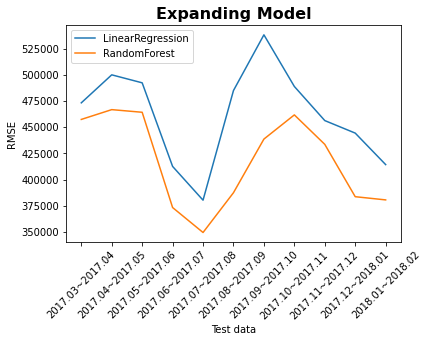

In [250]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(Expanding)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(Expanding)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("Expanding Model", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '2months for train data')

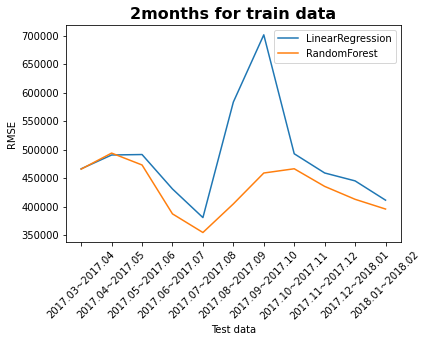

In [240]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(2 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(2 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("2months for train data", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '3months for train data')

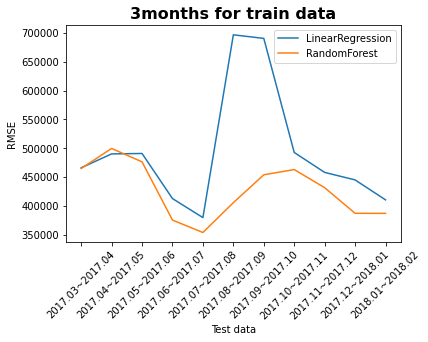

In [239]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(3 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(3 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("3months for train data", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '4months for train data')

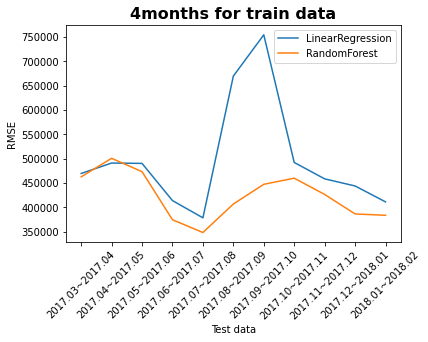

In [241]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(4 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(4 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("4months for train data", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '5months for train data')

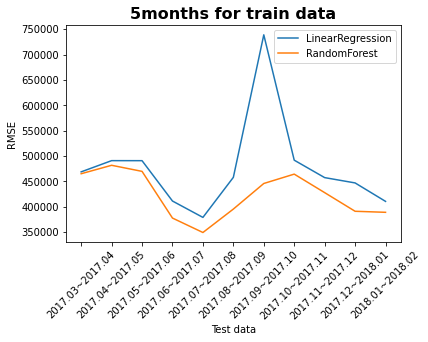

In [242]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(5 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(5 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("5months for train data", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '6months for train data')

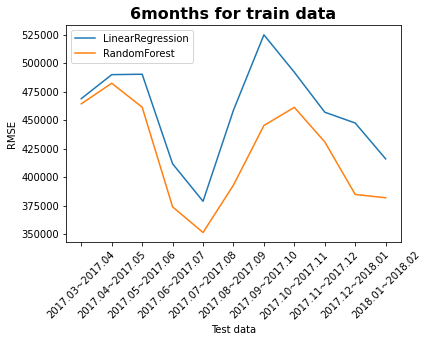

In [243]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(6 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(6 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("6months for train data", weight = 'bold', fontsize = 16)

Text(0.5, 1.0, '7months for train data')

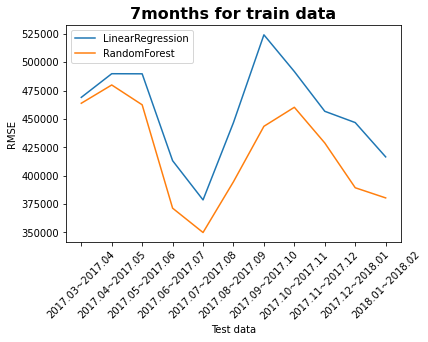

In [244]:
sns.lineplot(data=Results_Sl,x='Test Data' , y='Linear(7 months)',label='LinearRegression')
sns.lineplot(data=Results_Sl,x='Test Data' , y='RandomForest(7 months)',label='RandomForest')
plt.xlabel('Test data')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title("7months for train data", weight = 'bold', fontsize = 16)

* **The smaller the Root Mean Square Error is, the better the performance.**

* **In general, RMSE of RandomForest model is smaller than LinearRegression(OLS).**

* **RandomForest model is better (Reserach Question)**

Text(0.5, 1.0, 'Optimal Window size')

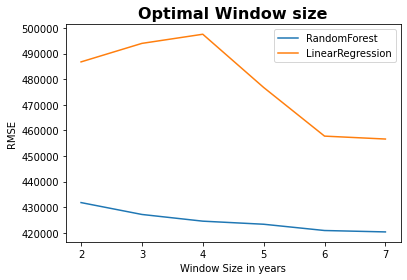

In [301]:
sns.lineplot(data=Results_Average,x='Window size' , y='RandomForest',label='RandomForest')
sns.lineplot(data=Results_Average,x='Window size' , y='Linear',label='LinearRegression')
plt.xlabel('Window Size in years')
plt.ylabel('RMSE')
plt.title("Optimal Window size", weight = 'bold', fontsize = 16)

* **When window size is bigger, RMSE is samller.**

* **RandomForest model is better (Reserach Question)**

Text(0.5, 1.0, 'Average of Each method and model')

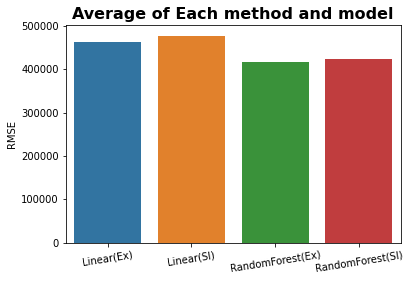

In [298]:
sns.barplot(data=Result_Average_both,x='Average' , y='Value')
plt.ylabel('RMSE')
plt.xlabel('')
plt.xticks(rotation=9)
plt.title("Average of Each method and model", weight = 'bold', fontsize = 16)

* **RMSE of Expanding method is smaller then RMSE of Sliding method.**